In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, ranges, params
from casting.preprocessing import (calculate_defect_rate, 
                                   drop_null, 
                                   remove_extreme_outliers, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data


from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees
from casting.trainner import train_tabnet, train_FTT

from casting.model.pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [3]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [ ]:
%load_ext autoreload
%autoreload 2

train, valid, test = load_data(params.model_name)

### Modeling

In [10]:
# model = train_extra_trees(train, valid)
# model = train_lightgbm(X_train, X_valid, y_train, y_valid)
# model = train_xgboost(train, valid)
# model = train_tabnet(X_train, X_valid, y_train, y_valid)
%load_ext autoreload
%autoreload 2
model = train_FTT(train, valid)

cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyboardInterrupt: 

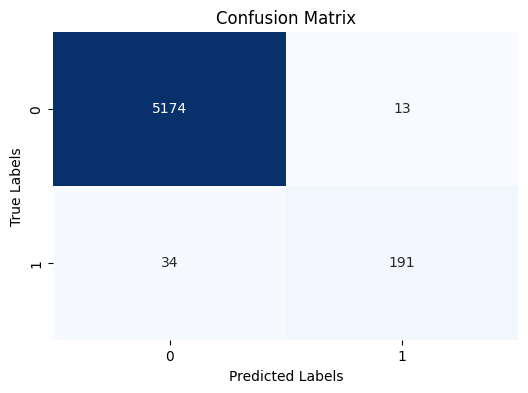

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산


X_test, y_test = test[columns.input_columns], test[columns.target_column]

y_pred = model.predict(X_test.values)
test_cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')

F1 Score: 0.8904
accuracy_score: 0.9913
precision_score: 0.9363
recall_score: 0.8489


## FTT Modeling